# Jones Time-Frequency Stimulus Response Figures

In [1]:
save_folder = '/home/jtauber/Documents/MillerData/analysis2/lfp/spectral/spectrogram/total_power/figures/'
save_figs = False

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as mt
import seaborn as sns

from pap.view import get_colors
from pap.utils import pickle_open
from pap.view import plot_spectrogram
import neural_analysis as na

sns.set()
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
all_results = pickle_open('jones_total_power_400_fw4.pickle')
# all_results_mary = pickle_open('mary_total_power_400_fw4.pickle')

# all_results = xr.concat([all_results_mary, all_results_jones], dim='session')

In [6]:
sids = all_results.session.data
conds = all_results.cond.data
areas = all_results.area.data
stims = all_results.stim.data

base_freq = all_results.freqs.data
timepts = all_results.timepts.data

In [7]:
np.where(timepts < 0)[0].size

6

In [8]:
stims_print = ['tone_only', 'cpt_tone', 'puff_only']
areas_ord = ['CPB', '7b', 'FEF', 'vlPFC']
conv_label = {'vlPFC': 'PFC',
              'FEF': '8A',
              'CPB': 'STG',
              '7b': 'PPC'}
name_conv = {'tone_only': 'Tone 1',
             'puff_only': 'UC Puff',
             'cpt_tone': 'Tone 2',
             'cpt_puff': 'C Puff'}

In [9]:
db_change_results = all_results.copy()

# baseline_cut = np.where()

for sid in sids:
    for cond in conds:
        for area in areas:
            for stim in stims:
                raw_data = all_results.loc[sid,cond,area,stim,:,:].data
                baseline = raw_data[:,:5].mean(1)[:,None]
                db_change = 10*np.log10(raw_data / baseline)
            
                db_change_results.loc[sid,cond,area,stim,:,:] = db_change
        
    

In [10]:
def cut_spec(spec, freq, cut_low, cut_high):
    cut_ind_high = np.where(freq <= cut_high)[0][-1] + 1
    cut_ind_low = np.where(freq >= cut_low)[0][0]
    
    return spec[:,cut_ind_low:cut_ind_high], freq[cut_ind_low:cut_ind_high]

In [11]:
def plot_db_change_results_new(stim, cut_low, cut_high):
    
    fig, ax = plt.subplots(4,3, figsize=(16,12), gridspec_kw={'width_ratios': (1,1,1)}, sharex=True, sharey=True)
    freq_orig = db_change_results.freqs.data
    
    low = -5
    high = 5
    
    phase_fontsize = 24
    tick_fontsize = 20
    tick_start = 10
    
    tick_space = 20
    
    label_fontsize = 24
    
    
    for i, area in enumerate(areas):
        awake = db_change_results.loc[:,'awake',area,stim,:,:].mean('session')
        drug = db_change_results.loc[:,'drug2',area,stim,:,:].mean('session')
        
        awake, freq = cut_spec(awake, freq_orig, cut_low, cut_high)
        drug, _ = cut_spec(drug, freq_orig, cut_low, cut_high)
        reshape = awake.shape
        
        n_sessions = db_change_results.session.data.size
        stats_awake = db_change_results.loc[:,'awake',area,stim,:,:].data
        stats_drug = db_change_results.loc[:,'drug2',area,stim,:,:].data
        
        stats_awake, _ = cut_spec(stats_awake, freq_orig, cut_low, cut_high)
        stats_drug, _ = cut_spec(stats_drug, freq_orig, cut_low, cut_high)
        
        n_sessions = db_change_results.session.data.size
        a = stats_awake.shape[1]
        b = stats_awake.shape[2]
        reshape = (a,b)
        
        pvals = np.zeros((a,b))
        
        for m in range(a):
            for n in range(b):
                s, pval = stats.wilcoxon(stats_awake[:,m,n], stats_drug[:,m,n])
                pvals[m,n] = pval
        
        
        pvals_flat = pvals.flatten()
        fdr, pvals = mt.fdrcorrection(pvals_flat)
        fdr_rs = np.reshape(fdr, reshape)
#         print(awake.shape)
#         print(fdr_rs.shape)
        
#         ttest = stats.ttest_rel(stats_awake, stats_drug, axis=2)
        
#         a = stats_awake.shape[0]
#         b = stats_awake.shape[1]
#         reshape = (a,b)
        
#         pvals_flat = ttest.pvalue.flatten()
#         fdr, pvals = mt.fdrcorrection(pvals_flat)
#         fdr_rs = np.reshape(fdr, reshape)
#         print(freq.shape)
        
#         fdr_rs = np.reshape(fdr, reshape)

        plot_spectrogram(timepts, freq, awake, cmap='coolwarm', clim=[low, high], ax=ax[i,0])
        if i == 0:
            ax[i,0].set_title('Awake', fontsize=phase_fontsize, fontweight='bold')
        ax[i,0].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,0].set_ylim([cut_low,85])
        ax[i,0].set_ylabel(conv_label[area] + f'\nFreq (Hz)', fontsize=label_fontsize, fontweight='bold')
        ax[i,0].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,0].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,0].tick_params(axis='both', labelsize=tick_fontsize)
        
        if i == 3:
            ax[i,0].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')

        plot_spectrogram(timepts, freq, drug, cmap='coolwarm', clim=[low, high], ax=ax[i,1])
        if i == 0:
            ax[i,1].set_title('Propofol', fontsize=phase_fontsize, fontweight='bold')
        ax[i,1].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,1].set_ylim([cut_low,85])
        ax[i,1].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,1].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,1].tick_params(axis='both', labelsize=tick_fontsize)
        
        if i == 3:
            ax[i,1].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')
            
        plot_spectrogram(timepts, freq, drug-awake, cmap='PRGn', clim=[low, high], ax=ax[i,2])
        ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
        if i == 0:
            ax[i,2].set_title('Propofol - Awake', fontsize=phase_fontsize, fontweight='bold')
        ax[i,2].vlines(0, -1, 90, linewidth=6, alpha=0.4)
        ax[i,2].set_ylim([cut_low,85])
        ax[i,2].set_yticks(np.arange(tick_start,cut_high,tick_space))
        ax[i,2].set_yticklabels(np.arange(tick_start,cut_high,tick_space))
        ax[i,2].tick_params(axis='both', labelsize=tick_fontsize)
        
        if i == 3:
            ax[i,2].set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')

    fig.suptitle(name_conv[stim], fontsize=32, fontweight='bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     fig.tight_layout()

<ipython-input-11-29605bc4a5fd>:91: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-11-29605bc4a5fd>:91: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-11-29605bc4a5fd>:91: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-11-29605bc4a5fd>:91: UserWarning: No contour levels were found within the data range.
  ax[i,2].contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)


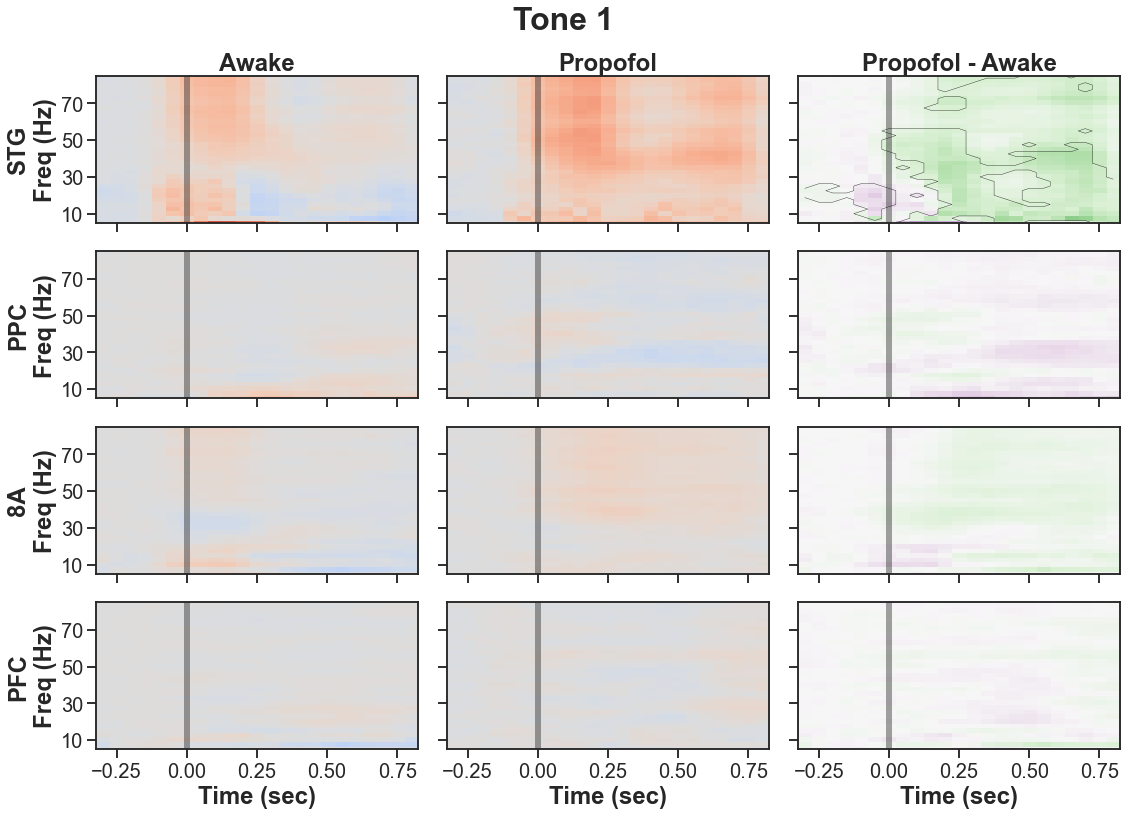

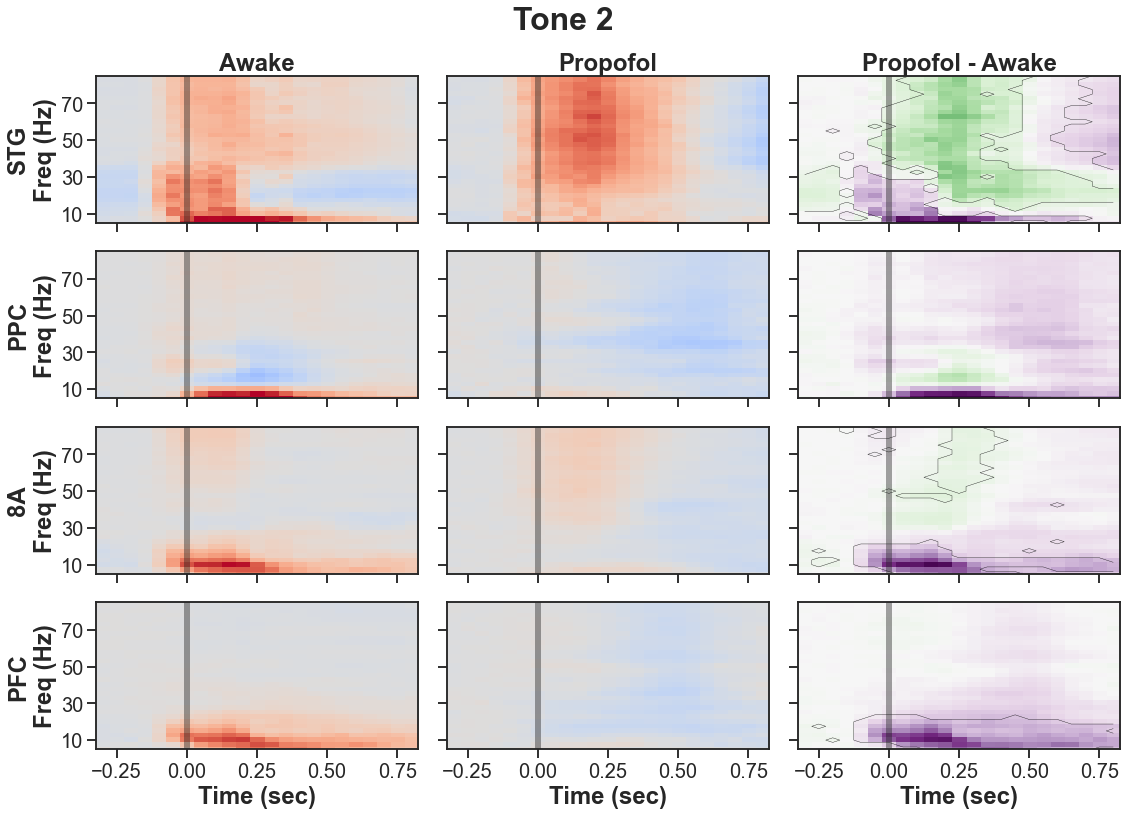

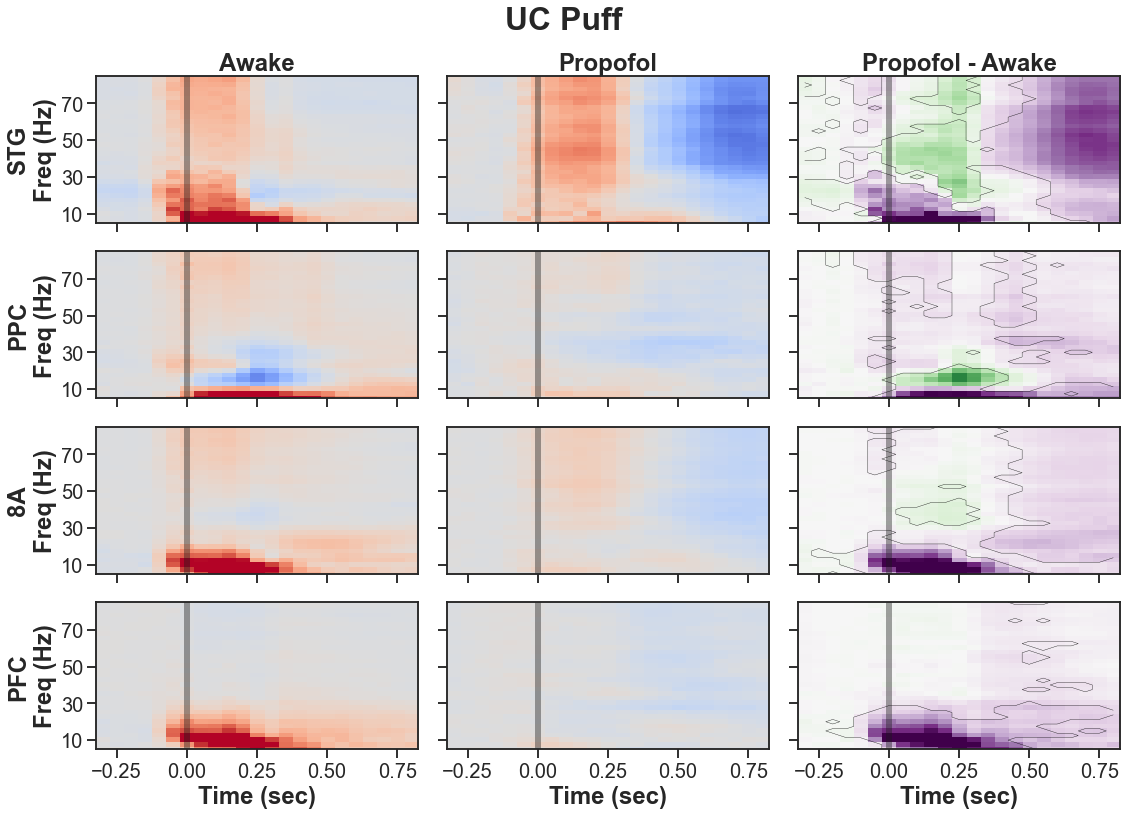

In [12]:
for stim in stims_print:
    plot_db_change_results_new(stim, 5, 90)
#     plt.savefig(f'stats_fixed_db_tp_{stim}.png', dpi=300)
#     plt.savefig(f'{save_folder}/{stim}_total_power_results.png', dpi=300)
#     plt.savefig(f'cut_db_tp_{stim}.png', dpi=300)
#     plt.savefig(f'cut_db_tp_{stim}.pdf', transparent=True)

In [9]:
def plot_colorbar():
    
    fig, ax = plt.subplots(figsize=(10,2))
    
    low = -5
    high = 5
    
    area = 'CPB'
    stim = 'tone_only'
    awake = db_change_results.loc[area,:,:,stim,'awake',:].mean('session')

    im = plot_spectrogram(timepts - 0.5, freq, awake, cmap='coolwarm', clim=[low, high])
    
    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'dB change from baseline', size='30', weight='bold')
    fig.tight_layout()

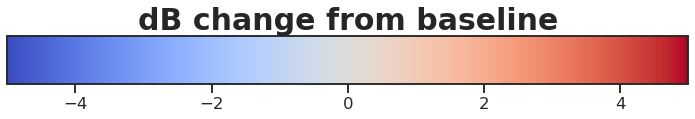

In [16]:
plot_colorbar()
# plt.savefig('colorbar_db_change.png', dpi=300)
plt.savefig(f'colorbar_db_change.pdf', transparent=True)

In [17]:
def plot_colorbar_stats():
    
    fig, ax = plt.subplots(figsize=(10,2))
    
    low = -5
    high = 5
    
    area = 'CPB'
    stim = 'tone_only'
    awake = db_change_results.loc[area,:,:,stim,'awake',:].mean('session')

    im = plot_spectrogram(timepts - 0.5, freq, awake, cmap='PRGn', clim=[low, high])
    
    
    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'dB change (propofol - awake)', size='30', weight='bold')
    fig.tight_layout()

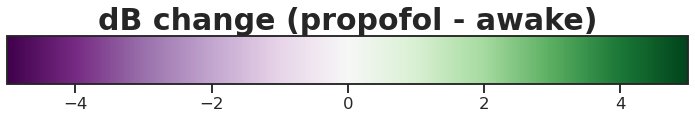

In [18]:
plot_colorbar_stats()
# plt.savefig('colorbar_db_stats.png', dpi=300)
plt.savefig(f'colorbar_db_stats.pdf', transparent=True)